# Intervention


In [1]:
from measureLM import visualizing, decoding

import torch
import transformer_lens


model = transformer_lens.HookedTransformer.from_pretrained("gpt2-medium").to("cpu")
model.tokenizer.pad_token = model.tokenizer.eos_token

Using pad_token, but it is not set yet.


Loaded pretrained model gpt2-medium into HookedTransformer
Moving model to device:  cpu


Using pad_token, but it is not set yet.


Loaded pretrained model gpt2-medium into HookedTransformer
Moving model to device:  cpu



prompt 0
layer 0: [(0.0002, 'Paris'), (0.0002, 'France'), (0.0007, 'Poland'), (0.0003, 'Warsaw')]
layer 1: [(0.0003, 'Paris'), (0.0002, 'France'), (0.0004, 'Poland'), (0.0005, 'Warsaw')]
layer 2: [(0.0003, 'Paris'), (0.0002, 'France'), (0.0004, 'Poland'), (0.0004, 'Warsaw')]
layer 3: [(0.0005, 'Paris'), (0.0002, 'France'), (0.0007, 'Poland'), (0.0008, 'Warsaw')]
layer 4: [(0.001, 'Paris'), (0.0004, 'France'), (0.0005, 'Poland'), (0.0007, 'Warsaw')]
layer 5: [(0.0007, 'Paris'), (0.0003, 'France'), (0.0003, 'Poland'), (0.0005, 'Warsaw')]
layer 6: [(0.0012, 'Paris'), (0.0003, 'France'), (0.0004, 'Poland'), (0.0004, 'Warsaw')]
layer 7: [(0.0016, 'Paris'), (0.0008, 'France'), (0.0016, 'Poland'), (0.0012, 'Warsaw')]
layer 8: [(0.0012, 'Paris'), (0.0012, 'France'), (0.0022, 'Poland'), (0.0019, 'Warsaw')]
layer 9: [(0.0081, 'Paris'), (0.0023, 'France'), (0.004, 'Poland'), (0.0015, 'Warsaw')]
layer 10: [(0.0244, 'Paris'), (0.0027, 'France'), (0.0068, 'Poland'), (0.0053, 'Warsaw')]
layer 11: [(

/Users/niklasstoehr/Code/measureLM/measureLM/visualizing.py:34: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


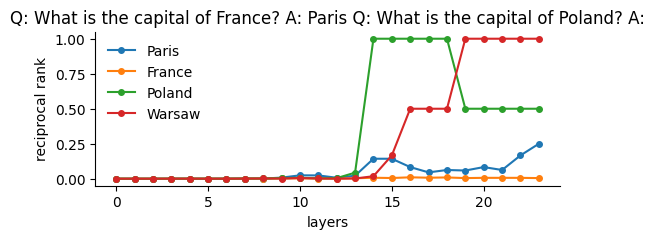

In [2]:
token_candidates = ["Paris", "France", "Poland", "Warsaw"]
prompts = ["Q: What is the capital of France? A: Paris Q: What is the capital of Poland? A:"]

## encoding
logits, activs, tokens = decoding.encode(prompts, model)
layer_scores = decoding.early_decoding(activs, model)

## scoring
tok_idx = decoding.token_select(tokens, model)
scored_tokens = decoding.scores_to_tokens(layer_scores[tok_idx], model, mode=token_candidates)
visualizing.visualize_token_ranks(scored_tokens, token_candidates, prompts)

## Make Intervention

In [5]:
import torch
import transformer_lens
from functools import partial
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)  

In [28]:
def patch_mlp_out(mlp_out_new, hook: HookPoint, old_activs: torch.Tensor, patch_tok_idx:int): 
    print(f'patching {hook.name}')
    mlp_out_old = old_activs[hook.name]
    mlp_out_new[:, patch_tok_idx, :] = mlp_out_old[:, patch_tok_idx, :]
    return mlp_out_new


def extract_resid_post(resid_post_layer, hook: HookPoint): 
    print(f'extracting {hook.name}')
    resid_post[...,hook.layer(),:] = resid_post_layer


def intervene(new_tokens, old_activs, patch_tok_idx = -1, l_start_end=[0, 99]):
    
    ## patching mlp output_________________
    patch_layers = list(range(0,model.cfg.n_layers))[l_start_end[0]:l_start_end[1]]
    patch_hook_fn = partial(patch_mlp_out, old_activs=old_activs, patch_tok_idx=patch_tok_idx)   
    patch_layers_fn = [(transformer_lens.utils.get_act_name("mlp_out", layer),patch_hook_fn) for layer in patch_layers]
    
    ## extracting residual stream out___________________
    global resid_post
    resid_post = torch.zeros(*new_tokens.shape, model.cfg.n_layers, model.cfg.d_model)
    extract_hook_fn = partial(extract_resid_post)
    extract_layers_fn = [(transformer_lens.utils.get_act_name("resid_post", layer),extract_hook_fn) for layer in range(0,model.cfg.n_layers)]

    patch_logits = model.run_with_hooks(new_tokens, fwd_hooks=patch_layers_fn+extract_layers_fn, return_type="logits", reset_hooks_end=True)
    return patch_logits, resid_post
            
    
#new_prompts = ["Q: What is the capital of Germany? A:"]
new_prompts = ["Germany, mug, table, Germany, mug, table,"]
new_logits, new_activs, new_tokens = decoding.encode(new_prompts, model)
pred = model.tokenizer.convert_ids_to_tokens(torch.topk(new_logits[:,-1,:], k =3).indices.tolist()[0])
print(pred)

patch_logits, resid_post = intervene(new_tokens, activs, patch_tok_idx=-1, l_start_end=[10,30])
resid_layer_scores = decoding.early_decoding(resid_post, model)


pred = model.tokenizer.convert_ids_to_tokens(torch.topk(new_scores[:,-1,:], k =3).indices.tolist()[0])
print(pred)

['Ġmug', 'ĠGermany', 'Ġtable']
extracting blocks.0.hook_resid_post
extracting blocks.1.hook_resid_post
extracting blocks.2.hook_resid_post
extracting blocks.3.hook_resid_post
extracting blocks.4.hook_resid_post
extracting blocks.5.hook_resid_post
extracting blocks.6.hook_resid_post
extracting blocks.7.hook_resid_post
extracting blocks.8.hook_resid_post
extracting blocks.9.hook_resid_post
patching blocks.10.hook_mlp_out
extracting blocks.10.hook_resid_post
patching blocks.11.hook_mlp_out
extracting blocks.11.hook_resid_post
patching blocks.12.hook_mlp_out
extracting blocks.12.hook_resid_post
patching blocks.13.hook_mlp_out
extracting blocks.13.hook_resid_post
patching blocks.14.hook_mlp_out
extracting blocks.14.hook_resid_post
patching blocks.15.hook_mlp_out
extracting blocks.15.hook_resid_post
patching blocks.16.hook_mlp_out
extracting blocks.16.hook_resid_post
patching blocks.17.hook_mlp_out
extracting blocks.17.hook_resid_post
patching blocks.18.hook_mlp_out
extracting blocks.18.hook


prompt 0
layer 0: [(0.0033, 'Germany'), (0.001, 'Berlin'), (0.0, 'mug'), (0.0001, 'table')]
layer 1: [(0.0333, 'Germany'), (0.002, 'Berlin'), (0.0, 'mug'), (0.0001, 'table')]
layer 2: [(0.0286, 'Germany'), (0.0028, 'Berlin'), (0.0, 'mug'), (0.0001, 'table')]
layer 3: [(0.0049, 'Germany'), (0.0008, 'Berlin'), (0.0, 'mug'), (0.0001, 'table')]
layer 4: [(0.0025, 'Germany'), (0.0003, 'Berlin'), (0.0, 'mug'), (0.0001, 'table')]
layer 5: [(0.0017, 'Germany'), (0.0003, 'Berlin'), (0.0, 'mug'), (0.0001, 'table')]
layer 6: [(0.002, 'Germany'), (0.0003, 'Berlin'), (0.0, 'mug'), (0.0001, 'table')]
layer 7: [(0.004, 'Germany'), (0.0007, 'Berlin'), (0.0, 'mug'), (0.0001, 'table')]
layer 8: [(0.0056, 'Germany'), (0.0005, 'Berlin'), (0.0, 'mug'), (0.0001, 'table')]
layer 9: [(0.0238, 'Germany'), (0.0006, 'Berlin'), (0.0, 'mug'), (0.0, 'table')]
layer 10: [(0.0141, 'Germany'), (0.0004, 'Berlin'), (0.0, 'mug'), (0.0001, 'table')]
layer 11: [(0.0026, 'Germany'), (0.0002, 'Berlin'), (0.0001, 'mug'), (0.

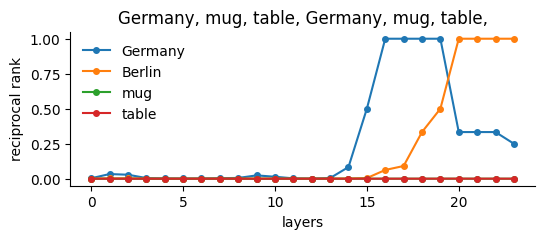

In [22]:
new_token_candidates = ["Germany", "Berlin", "mug", "table"]

## scoring
tok_idx = decoding.token_select(new_tokens, model)
scored_tokens = decoding.scores_to_tokens(resid_layer_scores[tok_idx], model, mode=new_token_candidates)
visualizing.visualize_token_ranks(scored_tokens, new_token_candidates, new_prompts)

## Extract residual stream

In [ ]:
def extract_resid_post(resid_post, hook: HookPoint): 
    print(f'extracting {hook.name}')
    resid_post_new[...,hook.layer(),:] = resid_post

new_token_candidates = ["Germany", "Berlin", "Poland", "Warsaw"]
new_prompts = ["Germany, mug, table, Germany, mug, table,"]
_, new_activs, new_tokens = decoding.encode(new_prompts, model)
new_layer_scores = decoding.early_decoding(new_activs, model)

resid_post_new = torch.zeros(*new_tokens.shape, model.cfg.n_layers, model.cfg.d_model)
extract_hook_fn = partial(extract_resid_post)
extract_layers_fn = [(transformer_lens.utils.get_act_name("resid_post", layer),extract_hook_fn) for layer in range(0,model.cfg.n_layers)]
new_scores = model.run_with_hooks(new_tokens, fwd_hooks=extract_layers_fn, return_type=None)

In [ ]:
new_token_candidates = ["Germany", "Berlin", "mug", "table"]

## scoring
tok_idx = decoding.token_select(new_tokens, model)
scored_tokens = decoding.scores_to_tokens(new_layer_scores[tok_idx], model, mode=new_token_candidates)
visualizing.visualize_token_ranks(scored_tokens, new_token_candidates, new_prompts)